# Simulations

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import math as math
import random as random
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


### Local Packages ###
from utils.Prediction import *
from utils.Selector import *
from utils.Auxiliary import *
from utils.Main import *

# Input

In [2]:
### Input ###
DataFile = "Iris"
rashomon_bound_adder = .45
regularization = 0.1
TestProportion = 0.2

# Train TreeFarms

In [3]:
### Load Data ###
df = LoadData(DataFile)

### Train/Test split ###
X_Train, X_Test, y_Train, y_Test = train_test_split(df.loc[:, df.columns != "Y"], df["Y"], test_size=TestProportion)
df_Train = X_Train.copy()
df_Train.insert(0, 'Y', y_Train)
df_Test = X_Test.copy()
df_Test.insert(0, 'Y', y_Test)

In [4]:
## Train TreeFarms Model ###
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

null
Finding Optimal Objective...treefarms reported successful execution

{
  "false": {
    "false": {
      "complexity": 0.10000000149011612,
      "loss": 0.02500000223517418,
      "name": "Y",
      "prediction": 1
    },
    "feature": 9,
    "name": "PetalWidth_1",
    "reference": 1.0,
    "relation": "==",
    "true": {
      "complexity": 0.10000000149011612,
      "loss": 0.0,
      "name": "Y",
      "prediction": 0
    },
    "type": "rational"
  },
  "feature": 11,
  "model_objective": 0.34166669845581055,
  "name": "PetalWidth_3",
  "reference": 1.0,
  "relation": "==",
  "true": {
    "complexity": 0.10000000149011612,
    "loss": 0.01666666753590107,
    "name": "Y",
    "prediction": 2
  },
  "type": "rational"
}
{
  "false": {
    "false": {
      "complexity": 0.10000000149011612,
      "loss": 0.0,
      "name": "Y",
      "prediction": 0
    },
    "feature": 10,
    "name": "PetalWidth_2",
    "reference": 1.0,
    "relation": "==",
    "true": {
      "complexi

# Set Up

In [5]:
### Duplicate and Unique ###
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()

### Set ###
PredictionArray = PredictionArray_Unique

### Tree Classification Accuracy ###
TreeClassificationAccuracy = PredictionArray.eq(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationAccuracy))

### Threshold Values ###
EpsilonVec = BestAccuracy - TreeClassificationAccuracy
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))
ThresholdValues = np.linspace(MinEpsilon, MaxEpsilon, 100)  # Adjust resolution as needed

# Accuracy

In [6]:
### Threshold of Training Data ###
Epsilon_F1Score = []
Epsilon_ClassAccuracy = []
for Threshold in ThresholdValues:

    # Filter Models Based on Threshold
    ModelIndices = EpsilonVec[EpsilonVec <= Threshold].index.tolist()
    Test_Predictions = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Test.loc[:, df_Test.columns != "Y"]) for i in ModelIndices]))
    Test_Predictions.columns = df_Test.index.astype(str)

    # Compute Ensemble Prediction (Mode)
    EnsemblePrediction = pd.Series(stats.mode(Test_Predictions, axis=0, keepdims=True)[0].flatten())
    EnsemblePrediction.index = df_Test["Y"].index

    # Compute Metrics
    F1Score = f1_score(df_Test["Y"], EnsemblePrediction, average='micro')
    ClassAccuracy = np.mean(EnsemblePrediction == df_Test["Y"])

    # Append Metrics
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassAccuracy.append(ClassAccuracy)

# Plot

## Model Length

In [7]:
ThresholdValues

array([0.        , 0.00614478, 0.01228956, 0.01843434, 0.02457912,
       0.03072391, 0.03686869, 0.04301347, 0.04915825, 0.05530303,
       0.06144781, 0.06759259, 0.07373737, 0.07988215, 0.08602694,
       0.09217172, 0.0983165 , 0.10446128, 0.11060606, 0.11675084,
       0.12289562, 0.1290404 , 0.13518519, 0.14132997, 0.14747475,
       0.15361953, 0.15976431, 0.16590909, 0.17205387, 0.17819865,
       0.18434343, 0.19048822, 0.196633  , 0.20277778, 0.20892256,
       0.21506734, 0.22121212, 0.2273569 , 0.23350168, 0.23964646,
       0.24579125, 0.25193603, 0.25808081, 0.26422559, 0.27037037,
       0.27651515, 0.28265993, 0.28880471, 0.29494949, 0.30109428,
       0.30723906, 0.31338384, 0.31952862, 0.3256734 , 0.33181818,
       0.33796296, 0.34410774, 0.35025253, 0.35639731, 0.36254209,
       0.36868687, 0.37483165, 0.38097643, 0.38712121, 0.39326599,
       0.39941077, 0.40555556, 0.41170034, 0.41784512, 0.4239899 ,
       0.43013468, 0.43627946, 0.44242424, 0.44856902, 0.45471

# Accuracy by Rashomon Threshold

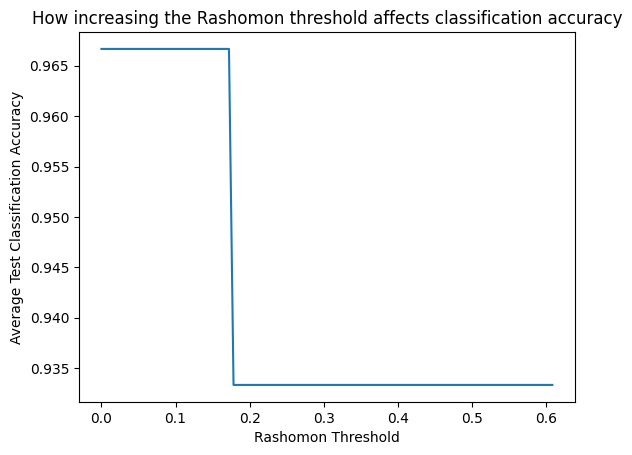

In [8]:
### Plot Accuracy ###
plt.plot(ThresholdValues, Epsilon_ClassAccuracy, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("How increasing the Rashomon threshold affects classification accuracy")
plt.show()

# F1 by Rashomon Threshold

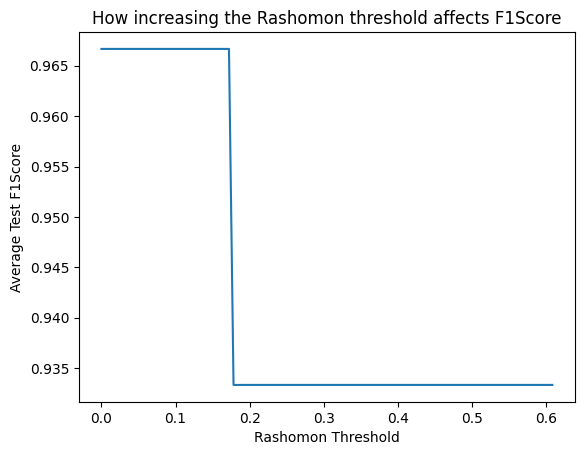

In [9]:
plt.plot(ThresholdValues, Epsilon_F1Score, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("How increasing the Rashomon threshold affects F1Score")
plt.show()